## Problem 3: Multiple Regression

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import stan

import arviz as az

import nest_asyncio
nest_asyncio.apply()

### Load and Preprocess Data

In [30]:
# Load dataset
df = pd.read_csv("data/insurance.csv")

# Select predictors and target
X_raw = df[['bmi', 'age', 'children']]
y_raw = df['charges']

# Standardize predictors
scaler = StandardScaler().fit(X_raw)
X = scaler.transform(X_raw)

# Normalize target
y_mean, y_std = y_raw.mean(), y_raw.std()
y = (y_raw - y_mean) / y_std

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Stan Code

In [ ]:
program_code = """
data {
  int<lower=1> N;            
  int<lower=1> K;            
  matrix[N, K] X;           
  vector[N] y;        
}
parameters {
  real alpha;                
  vector[K] beta;            
  real<lower=0> sigma;       
}
model {
  // Priors
  sigma ~ inv_gamma(2, 1);
  alpha ~ normal(0, 10);
  beta ~ normal(0, 1);

  // Likelihood
  y ~ normal(alpha + X * beta, sigma);
}
"""

### Model Fitting

In [ ]:
# Prepare data
stan_dict = {
    'N': len(y_train),
    'K': X_train.shape[1],
    'X': X_train.tolist(),
    'y': y_train.tolist(), 
}

# Compile the model
posterior = stan.build(program_code, data=stan_dict, random_seed=42)

# Sample from the posterior
fit = posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   1% (200/14000)
Sampling:   3% (400/14000)
Sampling:   4% (600/14000)
Sampling:   6% (800/14000)
Sampling:   9% (1200/14000)
Sampling:  11% (1600/14000)
Sampling:  14% (1900/14000)
Sampling:  16% (2200/14000)
Sampling:  18% (2500/14000)
Sampling:  19% (2700/14000)
Sampling:  26% (3600/14000)
Sampling:  30% (4200/14000)
Sampling:  41% (5700/14000)
Sampling:  60% (8400/14000)
Sampling:  75% (10500/14000)
Sampling:  92% (12900/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000417 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000421 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.21 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be r

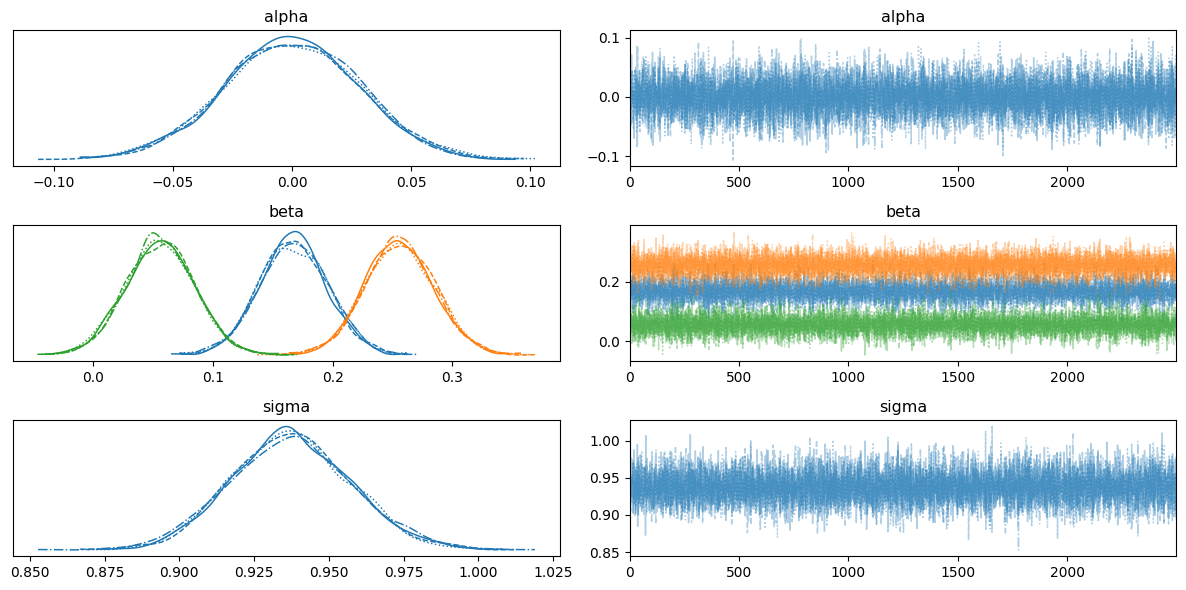

In [23]:
_ = az.plot_trace(fit, var_names=['alpha', 'beta', 'sigma'])
plt.tight_layout()

For all of the variables, traceplots show good convergence and mixing. 

In [24]:
az.summary(fit, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.029,-0.055,0.054,0.0,0.0,12699.0,7608.0,1.0
beta[0],0.167,0.029,0.114,0.221,0.0,0.0,12365.0,7666.0,1.0
beta[1],0.256,0.029,0.203,0.312,0.0,0.0,12466.0,7781.0,1.0
beta[2],0.056,0.029,0.001,0.108,0.0,0.0,11711.0,7533.0,1.0
sigma,0.937,0.020,0.899,0.975,0.0,0.0,12230.0,7782.0,1.0


Based on the summary, we can see that the model converged and the estimates are reliable (i.e. r_hat are 1.0, bulk and tail ess are all high, and mcse are all 0.0). 

Since beta[1] has the largest coefficient (0.258), **Age** is the best predictor of insurance charges in this data set. 


### Use the Bayesian Ridge regression

In [25]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
# Fit Bayesian Ridge Regression
model = BayesianRidge()
model.fit(X_train, y_train)

# Print Coefficients
print("Intercept:", model.intercept_)
print("Coefficients:")
for name, coef in zip(['bmi', 'age', 'children'], model.coef_):
    print(f"  {name}: {coef:.4f}")

Intercept: -0.00047866546093291697
Coefficients:
  bmi: 0.1636
  age: 0.2500
  children: 0.0550


As we can see, **Age**'s coefficient is the largest, which matches with result from our Stan model.  

In [27]:
# Evaluate on Test Set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Set MSE: {mse:.2f}")
print(f"Test Set R² Score: {r2:.2f}")


Test Set MSE: 0.90
Test Set R² Score: 0.15


Bayesian Ridge Regression in scikit-learn is a faster, simpler method that uses an approximate approach to estimate the model. It assumes fixed, standard priors and finds the best parameters by maximizing likelihood, rather than sampling.

In contrast, the custom Bayesian model uses full sampling to estimate the entire range of possible parameter values. This gives more flexibility and a deeper understanding of uncertainty, but it takes longer to run and is more complex to set up.

As a result, while the custom model offers more precise and comprehensive uncertainty quantification and modeling flexibility, the Bayesian Ridge implementation in scikit-learn is faster and easier to use for standard regression problems.

## Problem 4: Predictive Distribution

### Calculate RMSE using Bayesian ridge

In [43]:
# Get the predictive mean and standard deviation for each test point
y_mean, y_std = model.predict(X_test, return_std=True)

# Compute RMSE of the predictive means
rmse_mean = np.sqrt(np.mean((y_mean - y_test) ** 2))
print(f"RMSE (predictive means): {rmse_mean:.3f}")


RMSE (predictive means): 0.946


In [44]:
# Sample from the predictive distribution at each test point
n_draws = 1000
rng = np.random.RandomState(0)
# shape will be (n_test, n_draws)
y_samples = rng.normal(loc=y_mean[:, None], scale=y_std[:, None], size=(len(y_mean), n_draws))

# For each draw (across all test points) compute an RMSE
rmse_samples = np.sqrt(np.mean((y_samples - y_test[:, None])**2, axis=0))

# Summarize that distribution
print(f"Mean of RMSE distribution: {rmse_samples.mean():.3f}")
print(f"95% credible interval: [{np.percentile(rmse_samples, 2.5):.3f}, {np.percentile(rmse_samples, 97.5):.3f}]")

Mean of RMSE distribution: 1.330
95% credible interval: [1.235, 1.428]


The RMSE of the predictive means is 0.946 so quite good predictions, but when we include predictive uncertainty the average RMSE rises to 1.330 (95% CI: [1.235, 1.428]). Collapsing to predictive means discards all information about each prediction’s uncertainty. To propagate uncertainty, we could try to draw many samples from each test‐point predictive distribution, compute the RMSE for each joint sample, and then summarize the resulting RMSE distribution.